### **1. Importation des données**


In [2]:
!git clone https://github.com/inesdfls/BLAZE

Cloning into 'BLAZE'...
remote: Enumerating objects: 2837, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2837 (delta 0), reused 0 (delta 0), pack-reused 2836 (from 2)
Receiving objects: 100% (2837/2837), 489.65 MiB | 16.07 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Updating files: 100% (2660/2660), done.


### **2. Fonctions pour récupérer Tmax, t(e) et t(a)**


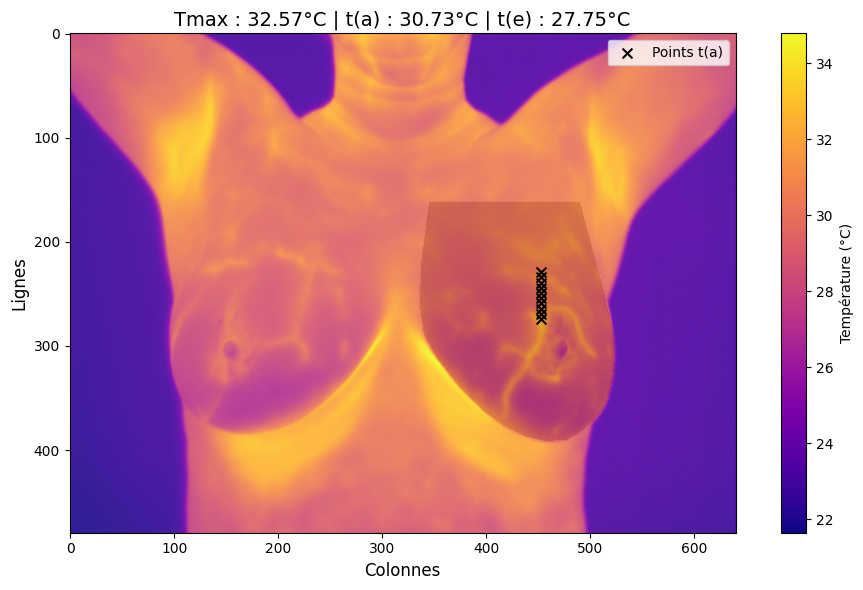

In [3]:
# Importer les bibliothèques nécessaires
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Fonction de traitement de la matrice thermique et du masque
def traitement_temperature_test(matrice_thermique, image_masque, pixels_par_cm=5, distance_a_cm=1):
    if image_masque.ndim == 3:
        masque_gris = cv2.cvtColor(image_masque, cv2.COLOR_BGR2GRAY)
    else:
        masque_gris = image_masque.copy()
    _, masque_binaire = cv2.threshold(masque_gris, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thermique_masquee = matrice_thermique * masque_binaire
    Tmax = np.max(thermique_masquee)
    ligne_Tmax, colonne_Tmax = np.unravel_index(np.argmax(thermique_masquee), thermique_masquee.shape)
    a_pixels = int(distance_a_cm * pixels_par_cm)

    temperatures_a = []
    points_a = []

    for i in range(10):
        y = ligne_Tmax - (i + 1) * a_pixels
        x = colonne_Tmax
        if 0 <= y < thermique_masquee.shape[0]:
            temperatures_a.append(thermique_masquee[y, x])
            points_a.append((x, y))  # Ajouter le point pour affichage

    t_a = np.mean(temperatures_a) if temperatures_a else np.nan
    t_e = np.mean(matrice_thermique[masque_binaire == 0])
    return Tmax, t_a, t_e, distance_a_cm, points_a, masque_binaire

# Charger la matrice thermique et le masque
chemin_matrice = "BLAZE/data/sick/1050/Matrizes/PAC_65_DN0.txt"
chemin_masque = "BLAZE/data/sick/1050/Segmentadas/PAC_65_DN0-esq.png"

matrice = np.loadtxt(chemin_matrice)
masque = cv2.imread(chemin_masque, cv2.IMREAD_GRAYSCALE)

# Appliquer le traitement
Tmax, t_a, t_e, distance_a_cm, points_a, masque_binaire = traitement_temperature_test(
    matrice, masque, pixels_par_cm=5, distance_a_cm=1
)

# Afficher l’image thermique avec masque superposé
plt.figure(figsize=(10, 6))
plt.imshow(matrice, cmap='plasma')
plt.colorbar(label='Température (°C)')
plt.imshow(masque_binaire, cmap='Grays', alpha=0.1)

# Afficher les points t(a)
if points_a:
    x_points, y_points = zip(*points_a)
    plt.scatter(x_points, y_points, color='black', marker='x', label='Points t(a)', s=50)

plt.title(f"Tmax : {Tmax:.2f}°C | t(a) : {t_a:.2f}°C | t(e) : {t_e:.2f}°C", fontsize=14, color='black')
plt.xlabel('Colonnes', fontsize=12)
plt.ylabel('Lignes', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# Importer les bibliothèques nécessaires
import numpy as np
import cv2
import os
import pandas as pd

# Définir la fonction de traitement d'une matrice thermique
def traitement_temperature(matrice_thermique, image_masque, pixels_par_cm=5, distance_a_cm=1):
    # Convertir le masque en niveaux de gris si nécessaire
    if image_masque.ndim == 3:
        masque_gris = cv2.cvtColor(image_masque, cv2.COLOR_BGR2GRAY)
    else:
        masque_gris = image_masque.copy()

    # Binariser le masque : 1 = région d'intérêt, 0 = reste
    _, masque_binaire = cv2.threshold(masque_gris, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Appliquer le masque sur la matrice thermique
    thermique_masquee = matrice_thermique * masque_binaire

    # Trouver la température maximale (Tmax) et sa position
    Tmax = np.max(thermique_masquee)
    ligne_Tmax, colonne_Tmax = np.unravel_index(np.argmax(thermique_masquee), thermique_masquee.shape)

    # Calculer la distance en pixels correspondant à 'a' cm
    a_pixels = int(distance_a_cm * pixels_par_cm)

    # Chercher la température à une distance 'a' le long de l'axe vertical
    temperatures_a = []
    for i in range(10):
        y = ligne_Tmax - (i + 1) * a_pixels
        x = colonne_Tmax
        if 0 <= y < thermique_masquee.shape[0]:
            temperatures_a.append(thermique_masquee[y, x])

    t_a = np.mean(temperatures_a) if temperatures_a else np.nan
    t_e = np.mean(matrice_thermique[masque_binaire == 0])

    return Tmax, t_a, t_e, distance_a_cm

# === Parcourir le dataset ===
repertoire_base = 'BLAZE/data'
resultats = []

for etiquette in ['healthy', 'sick']:
    chemin_etiquette = os.path.join(repertoire_base, etiquette)
    for dossier_patient in os.listdir(chemin_etiquette):
        chemin_patient = os.path.join(chemin_etiquette, dossier_patient)
        chemin_matrices = os.path.join(chemin_patient, 'Matrizes')
        chemin_segmentations = os.path.join(chemin_patient, 'Segmentadas')

        if not os.path.isdir(chemin_matrices) or not os.path.isdir(chemin_segmentations):
            continue  # Passer au suivant si dossiers manquants

        for fichier in os.listdir(chemin_matrices):
            if fichier.endswith('.txt'):
                try:
                    chemin_fichier_matrice = os.path.join(chemin_matrices, fichier)
                    matrice = np.loadtxt(chemin_fichier_matrice)
                    base_nom_fichier = fichier.replace('.txt', '')
                    masque_gauche = os.path.join(chemin_segmentations, f"{base_nom_fichier}-esq.png")
                    masque_droit = os.path.join(chemin_segmentations, f"{base_nom_fichier}-dir.png")

                    for fichier_masque in [masque_gauche, masque_droit]:
                        if os.path.exists(fichier_masque):
                            # Charger le masque en niveaux de gris
                            image_masque = cv2.imread(fichier_masque, cv2.IMREAD_GRAYSCALE)
                            Tmax, t_a, t_e, distance_a_cm = traitement_temperature(
                                matrice, image_masque, pixels_par_cm=5, distance_a_cm=1
                            )

                            # Ajouter les résultats
                            resultats.append({
                                'Patient': dossier_patient,
                                'Fichier': base_nom_fichier,
                                'Côté': 'gauche' if 'esq' in fichier_masque else 'droit',
                                'Étiquette': etiquette,
                                'Tmax (°C)': Tmax,
                                't(a) (°C)': t_a,
                                't(e) (°C)': t_e,
                                'a (cm)': distance_a_cm
                            })
                except Exception as e:
                    print(f"Erreur avec le fichier {fichier} : {e}")

# === Exporter les résultats sous forme de fichier CSV ===
df = pd.DataFrame(resultats)
df.to_csv('donnees_pour_signatures_thermiques.csv', index=False)
print("Fichier CSV généré : donnees_pour_signatures_thermiques.csv")

Erreur avec le fichier PAC_36_ESTATICO.txt : could not convert string '31,1' to float64 at row 0, column 1.
Erreur avec le fichier PAC_35_ESTATICO.txt : could not convert string '31,78' to float64 at row 0, column 1.
Fichier CSV généré : donnees_pour_signatures_thermiques.csv


### **3. Statistiques des résultats obtenus**


In [5]:
# Import des bibliothèques nécessaires
import pandas as pd

# Lire le CSV
df = pd.read_csv('donnees_pour_signatures_thermiques.csv')

# Séparer healthy et sick
df_healthy = df[df['Étiquette'] == 'healthy']
df_sick = df[df['Étiquette'] == 'sick']

# Colonnes à analyser
cols = ['Tmax (°C)', 't(a) (°C)', 't(e) (°C)', 'a (cm)']

# Fonction pour afficher les stats
def stats_table(df_subset, label):
    print(f"\nStatistiques pour {label.upper()} :")
    print(df_subset[cols].describe())

# Afficher les statistiques
stats_table(df_healthy, 'healthy')
stats_table(df_sick, 'sick')



Statistiques pour HEALTHY :
        Tmax (°C)   t(a) (°C)   t(e) (°C)  a (cm)
count  762.000000  762.000000  762.000000   762.0
mean    32.241995   24.737412   27.053889     1.0
std      1.184113    9.589456    0.722504     0.0
min     28.500000    0.000000   25.561391     1.0
25%     31.380000   26.685250   26.493593     1.0
50%     32.385000   28.219500   27.015512     1.0
75%     33.080000   29.641250   27.468931     1.0
max     35.230000   31.984000   28.776357     1.0

Statistiques pour SICK :
        Tmax (°C)   t(a) (°C)   t(e) (°C)  a (cm)
count  740.000000  740.000000  740.000000   740.0
mean    34.142730   29.231122   28.477523     1.0
std      1.150576    7.667572    1.228396     0.0
min     28.970000    0.000000   24.353085     1.0
25%     33.517500   30.044500   28.115471     1.0
50%     34.160000   31.602000   28.619455     1.0
75%     34.922500   32.555500   29.216467     1.0
max     36.440000   34.840000   30.837083     1.0
